# Building neural networks in Tensorflow and Keras

# Tensorflow
  
Tensorflow is an open source library machine learning library developed by the Google Brain team for internal use. It was released under the Apache 2.0 open source license in November 9, 2015.  
  
Tensorflow is a computational framework that allows you to construct machine learning models at different levels of abstraction, from high-level, object-oriented APIs like Keras, down to the C++ kernels that Tensorflow is built upon. The higher levels of abstraction are simpler to use, but less flexible, and your choice of implementation should reflect the problem you are trying to solve.  
  
Tensorflow uses a [dataflow graph](https://www.tensorflow.org/guide/graphs) to represent your computation
in terms of the dependencies between individual operations, such that you first build a Tensorflow **graph** to represent your model, and then create a Tensorflow **session** to run the graph.
  
In this guide we will analyze the same data as we did in our NumPy and scikit-learn tutorial, gathered
from the MNIST database of images. We will give an introduction to the lower level Python APIs, and see how we use them to build our graph. Then we will build (effectively) the same graph in Keras, to see just how simple solving a machine learning problem can be.  
  
If you prefer you can also take a look at the official guides on [low level APIs](https://www.tensorflow.org/guide/low_level_intro) and [Keras](https://www.tensorflow.org/guide/keras).

inputs = (n_inputs, pixel_width, pixel_height) = (1797, 8, 8)
labels = (n_inputs) = (1797,)
X = (n_inputs, n_features) = (1797, 64)


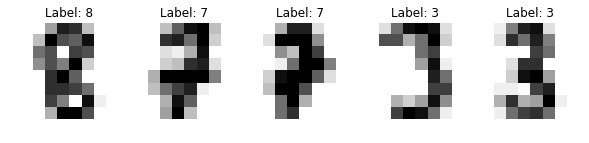

In [2]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print("X = (n_inputs, n_features) = " + str(inputs.shape))


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()


In [3]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

labels = to_categorical(labels)

# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

Using TensorFlow backend.


In [4]:
import tensorflow as tf

class DNNModel:
    def __init__(
        self,
        n_features,
        n_neurons_layer1=100,
        n_neurons_layer2=50,
        n_categories=2,
        eta=0.1,
    ):
        
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

        self.n_features = n_features
        self.n_neurons_layer1 = n_neurons_layer1
        self.n_neurons_layer2 = n_neurons_layer2
        self.n_categories = n_categories
        
        self.eta = eta
        
        self.create_placeholders()
        self.create_DNN()
        self.create_loss()
        self.create_accuracy()
        self.create_optimiser()
    
    def create_placeholders(self):
        # placeholders are fine here, but Datasets are the preferred method
        # of streaming data into a  model
        with tf.name_scope('data'):
            self.X = tf.placeholder(tf.float32, shape=(None, self.n_features), name='X_data')
            self.Y = tf.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
    
    def create_DNN(self):
        with tf.name_scope('DNN'):
            
            # Fully connected layer 1
            W_fc1 = self.weight_variable([self.n_features, self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            b_fc1 = self.bias_variable([self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            a_fc1 = tf.nn.sigmoid(tf.matmul(self.X, W_fc1) + b_fc1)
            
            # Fully connected layer 2
            W_fc2 = self.weight_variable([self.n_neurons_layer1, self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            b_fc2 = self.bias_variable([self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            a_fc2 = tf.nn.sigmoid(tf.matmul(a_fc1, W_fc2) + b_fc2)
            
            # Output layer
            W_out = self.weight_variable([self.n_neurons_layer2, self.n_categories], name='out', dtype=tf.float32)
            b_out = self.bias_variable([self.n_categories], name='out', dtype=tf.float32)
            self.z_out = tf.matmul(a_fc2, W_out) + b_out
    
    def create_loss(self):
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.Y, logits=self.z_out))

    def create_accuracy(self):
        with tf.name_scope('accuracy'):
            correct_prediction = tf.equal(tf.argmax(self.Y,1), tf.argmax(self.z_out, 1))
            correct_prediction = tf.cast(correct_prediction, tf.float32)
            self.accuracy = tf.reduce_mean(correct_prediction)
    
    def create_optimiser(self):
        with tf.name_scope('optimizer'):
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.eta).minimize(self.loss, global_step=self.global_step)
            
    def weight_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def bias_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name, dtype=dtype)

In [5]:
from sklearn.metrics import accuracy_score

epochs = 2
batch_size = 100
n_features = X_train.shape[1]
n_neurons_layer1 = 100
n_neurons_layer2 = 50
n_categories = 10

eta_vals = np.logspace(-5, 0, 6)
lmbd_vals = np.logspace(-5, 0, 6)


In [6]:
DNN = DNNModel(n_features, n_neurons_layer1, n_neurons_layer2, n_categories, eta=0.1)

n_inputs = X_train.shape[0]
iterations = n_inputs // batch_size
data_indices = np.arange(n_inputs)

epochs = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        for j in range(iterations):
            chosen_datapoints = np.random.choice(data_indices, size=batch_size, replace=False)
            batch_X, batch_Y = X_train[chosen_datapoints], Y_train[chosen_datapoints]
            
            sess.run([DNN.loss, DNN.optimizer],
                     feed_dict={DNN.X: batch_X,
                                DNN.Y: batch_Y})
            accuracy = sess.run(DNN.accuracy,
                                feed_dict={DNN.X: batch_X,
                                           DNN.Y: batch_Y})
            step = sess.run(DNN.global_step)
    
    train_loss, train_accuracy = sess.run([DNN.loss, DNN.accuracy],
                                          feed_dict={DNN.X: X_train,
                                                     DNN.Y: Y_train})
    
    test_loss, test_accuracy = sess.run([DNN.loss, DNN.accuracy],
                                        feed_dict={DNN.X: X_test,
                                                   DNN.Y: Y_test})
    
    print("Train accuracy: %.3f" % train_accuracy)
    print("Test accuracy: %.3f" % test_accuracy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Train accuracy: 0.998
Test accuracy: 0.975


In [7]:
writer = tf.summary.FileWriter('logs/')
writer.add_graph(tf.get_default_graph())

In [8]:
from keras.models import Sequential
from keras.layers import Dense

def create_DNN(n_features, n_neurons_layer1, n_neurons_layer2, n_categories):
    model = Sequential()
    model.add(Dense(n_neurons_layer1, input_dim=n_features, activation='sigmoid'))
    model.add(Dense(n_neurons_layer1, activation='sigmoid'))
    model.add(Dense(n_categories, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    return model

model = create_DNN(n_features, n_neurons_layer1, n_neurons_layer2, n_categories)
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)

scores = model.evaluate(X_test, Y_test)
print("Accuracy: %.3f" % scores[1])

360/360 [==============================] - 0s 61us/step
Accuracy: 0.897
